In [101]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import cumtrapz
import scipy.constants as const
import pandas as pd
import matplotlib.pyplot as plt
import uncertainties as unc
from uncertainties import unumpy
%matplotlib inline

def secondDerivative(x,y):
    deri = np.ones(len(x)-2)
    for i in range(len(deri)):
        deri[i] = (y[i+2] - 2*y[i+1] + y[i]) / (x[i+2] - x[i])**2
    return deri

def restGlied(x,y):
    return (max(x)-min(x))**3/(len(x)**2) / 24 * max(secondDerivative(x, y))

    
def durchlasskurve(nu, nu0, Q, Ue2):
    return Ue2/Q**2 * 1/((nu/nu0)**2 + (nu/nu0)**-2 + Q**-2 -2)

def gerade(x, m, b):
    return m*x+b

def eFunk(x, m, b):
    return 10**(b) * x**m

def deltaNu(nu, R):
    if 10 <= nu < 100:
        return 0.15*nu - 0.3
    if 100 <= nu < 10e3:
        return 0.14*nu + 0.7
    if 10e3 <= nu < 50e3:
        return 0.135*nu + 0.05e3
    if 50e3 <= nu <= 100e3:
        if R == 2200:
            return 0.115*nu + 1.05e3
        elif R == 4680:
            return 0.109*nu + 1.2e3
        else:
            print('Falscher Widerstand')
            return -1
    else:
        print('Out of Range. Nu:{}'.format(nu))
        return -1

def fillNu(row, R):
    if np.isnan(row.dNu):
        return deltaNu(row.frequenz_Hz, R)
    else:
        return row.dNu


### Sinus Normal

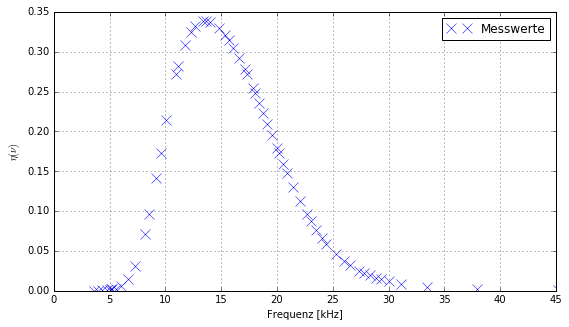

In [102]:
sin1 = pd.read_csv('daten_sin.csv', header=0, delimiter='\t', names=['frequenz', 'voltage','vN'])
sin1 = sin1.fillna(method='pad')

# Rauschen der Aparatur abziehen
eigenRauschen = pd.read_csv('eigenRauschen1.csv', header=0, delimiter='\t', index_col=0, names=['eigenRauschen'])
sin1 = sin1.join(eigenRauschen, on='vN', how='left')
sin1['voltage'] -= sin1['eigenRauschen']

#Einheiten Umrechnen

sin1['frequenzkHz'] = sin1.frequenz #Plot soll in kHz bleiben
sin1.frequenz *= 1000 # in Herz umrechnen
sin1.index = sin1.frequenz
sin1['voltage'] /= 1000 #in Volt umrechnen
sin1.sort_index(inplace=True)

# Verstärkungen aufzählen
V_in = 175e-3 #Eingangsspannung
V_ab = 1000 #Abschwächer
V_V = 1000 #Vorverstärkung
V_N = sin1.vN #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

sin1['voltageCorrected'] = sin1.voltage / (V_in/V_ab)**2 / (V_gl * V_N**2 * V_V**2)
sin1['verstaerkung'] = V_gl * V_V**2 * V_N



# Plot der Messewerte
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
ax.plot(sin1.frequenzkHz, sin1.voltageCorrected, linestyle='', marker='x', markersize=10, label='Messwerte')
ax.set_xlim((0,45))
ax.set_xlabel('Frequenz [kHz]')
ax.set_ylabel(r'$\eta(\nu)$')
ax.grid()
ax.legend(loc='best')
fig.savefig('results/sin.pdf')

plt.show()

# Latex Tabelle
sin1['v'] = sin1.voltageCorrected*1000
#sin1.to_latex('latex_sin1', float_format='%2.2f', header=False, index=False, columns=['frequenzkHz','vN','v'])

### Sinus Korrel

15021.62 \pm 18.02
8.09 \pm 0.26
\left(2.43 \pm 0.04\right) \times 10^{-1}


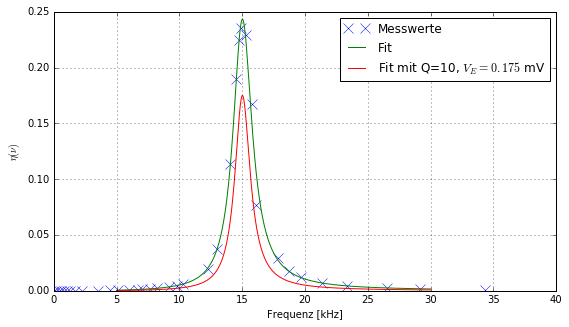

In [103]:
sin2 = pd.read_csv('daten_korrel_sin.csv', header=0, delimiter='\t', names=['frequenz', 'voltage','vN'])
sin2 = sin2.fillna(method='pad')

# Rauschen der Aparatur abziehen (Korrelationsaufbau)
eigenRauschen = pd.read_csv('eigenRauschen2.csv', header=0, delimiter='\t', index_col=0, names=['eigenRauschen'])
sin2 = sin2.join(eigenRauschen, on='vN', how='left')
sin2['voltage'] -= sin2['eigenRauschen']

#Einheiten Umrechnen
sin2['frequenzkHz'] = sin2.frequenz # Plot soll in kHz bleiben
sin2.frequenz *= 1000. # in Herz umrechnen
sin2.index = sin2.frequenz 
sin2['voltage'] /= 1000. #in Volt umrechnen
sin2.sort_index(inplace=True)



# Verstärkungen aufzählen
V_in = 175e-3 #Eingangsspannung
V_ab = 1000 #Abschwächer
V_V = 1000 #Vorverstärkung
V_N = sin2.vN *10 #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

sin2['voltageCorrected'] = sin2.voltage / (V_in/V_ab)**2 / V_gl / V_N**2 / V_V**2

# Fit und Plot
popt, pcov = curve_fit(durchlasskurve, sin2.frequenz, sin2.voltageCorrected, p0=[1e4,8,175e-3])
perr = np.sqrt(np.diag(pcov))

nu_0 = unc.ufloat(popt[0], perr[0])
Q = unc.ufloat(popt[1], perr[1])
U = unc.ufloat(popt[2], perr[2])

with open("results/sin2_nu0.fit", "w") as text_file:
    print('{:.2fL}'.format(nu_0), file=text_file)
    print('{:.2fL}'.format(nu_0))
with open("results/sin2_Q.fit", "w") as text_file:
    print('{:.2fL}'.format(Q), file=text_file)
    print('{:.2fL}'.format(Q))
with open("results/sin2_U.fit", "w") as text_file:
    print('{:.2eL}'.format(U), file=text_file)
    print('{:.2eL}'.format(U))
    
    
x = np.linspace(5e3, 30e3, 1000)

# Plot der Messewerte
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
ax.plot(sin2.frequenzkHz, sin2.voltageCorrected, linestyle='', marker='x', markersize=10, label='Messwerte')

y = durchlasskurve(x, popt[0], popt[1], popt[2])
ax.plot(x/1000,y, label='Fit')

y2 = durchlasskurve(x, popt[0], 10, 175e-3)
ax.plot(x/1000,y2, label='Fit mit Q=10, $V_E=0.175$ mV')

ax.set_xlim((0,40))
ax.set_xlabel('Frequenz [kHz]')
ax.set_ylabel(r'$\eta(\nu)$')
ax.grid()
ax.legend(loc='upper right')
fig.savefig('results/sin_korrel.pdf')

plt.show()
sin2['v'] = sin2.voltageCorrected*1000
#sin2.to_latex('latex_sin2', float_format='%2.3f', header=False, index=False, columns=['frequenzkHz','vN','v'])

### Calc Delta Nu

In [104]:
dNu1 = np.trapz(y=sin1.voltageCorrected.values, x=sin1.frequenz)
rG1 = restGlied(sin1.frequenz.values, sin1.voltageCorrected.values)
deltaNu1 = unc.ufloat(dNu1, rG1)

dNu2 = np.trapz(y=sin2.voltageCorrected.values, x=sin2.frequenz)
rG2 = restGlied(sin2.frequenz.values, sin2.voltageCorrected.values)
deltaNu2_file = unc.ufloat(dNu2, rG2)
deltaNu2 = unc.ufloat(dNu2, 0) #Error was too big, so we set it to 0 for further analysis

with open("results/sin1_DeltaNu.fit", "w") as text_file:
    print('{:.2fL}'.format(deltaNu1), file=text_file)
    print('{:.2fL}'.format(deltaNu1))

with open("results/sin2_DeltaNu.fit", "w") as text_file:
    print('{:.2fL}'.format(deltaNu2_file), file=text_file)
    print('{:.2fL}'.format(deltaNu2_file))



3880.49 \pm 25.27
721.66 \pm 8419.05


### Rauschzahl

In [105]:
U500 = unc.ufloat(706e-3, 0.02*706e-3)
F500 = U500 / (4*const.Boltzmann * 293 * 500 * deltaNu1 * 10**13)
with open("results/rausch1.fit", "w") as text_file:
    print('{:L}'.format(U500), file=text_file)
    print('F500_1={:L}'.format(U500))

U500_2 = unc.ufloat(625e-3, 0.02*625e-3)
F500_2 = U500 / (4*const.Boltzmann * 293 * 500 * deltaNu2 * 10**15)
with open("results/rausch2.fit", "w") as text_file:
    print('{:L}'.format(U500_2), file=text_file)
    print('F500_2={:L}'.format(U500_2))

F500_1=0.706 \pm 0.014
F500_2=0.625 \pm 0.013


### Widerstand 1 normal

m=\left(1.20 \pm 0.01\right) \times 10^{-16}
b=\left(2.92 \pm 0.45\right) \times 10^{-15}
kB=\left(2.63 \pm 0.02\right) \times 10^{-23}
            widerstand  voltage      vN  voltageNormed
widerstand                                            
0.6                0.6   0.0124  1000.0   1.240000e-15
51.2              51.2   0.1080  1000.0   1.080000e-14
100.4            100.4   0.1440  1000.0   1.440000e-14
148.8            148.8   0.2100  1000.0   2.100000e-14
205.0            205.0   0.2760  1000.0   2.760000e-14


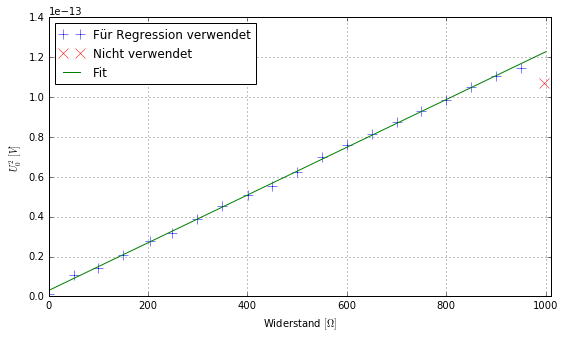

In [106]:
daten = pd.read_csv('daten_wid1.csv', header=0, delimiter='\t', names=['widerstand', 'voltage','vN'])


daten = daten.fillna(method='pad')
daten.index = daten.widerstand
daten.voltage /= 1000 #in Volt umrechnen

# Verstärkungen aufzählen
V_V = 1000 #Vorverstärkung
V_N = daten.vN #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

daten['voltageNormed'] = daten.voltage / (V_gl * V_N**2 * V_V**2)


noFit = daten.query('widerstand > 960')
daten = daten.query('widerstand <= 960')

# Fit
popt, pcov = curve_fit(gerade, daten.widerstand, daten.voltageNormed)
perr = np.sqrt(np.diag(pcov))

x = np.linspace(0, 1000, 20)
y = gerade(x,popt[0], popt[1])
m = unc.ufloat(popt[0], perr[0])
b = unc.ufloat(popt[1], perr[1])
kB1 = m/(4 * deltaNu1 * 293.15)

with open("results/wid1_m.fit", "w") as text_file:
    print('{:.3L}'.format(m), file=text_file)
    print('m={:.3L}'.format(m))
with open("results/wid1_b.fit", "w") as text_file:
    print('{:.3L}'.format(b), file=text_file)
    print('b={:.3L}'.format(b))
with open("results/wid1_kb.fit", "w") as text_file:
    print('{:.3L}'.format(kB1), file=text_file)
    print('kB={:.3L}'.format(kB1))


fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
daten.voltageNormed.plot(ax=ax, linestyle='', marker='+', color='blue', markersize=10, label='Für Regression verwendet')
noFit.voltageNormed.plot(ax=ax, linestyle='', marker='x', color='red', markersize=10, label='Nicht verwendet')
ax.plot(x,y, label='Fit', color='green')
ax.set_xlim((0,1010))
ax.set_xlabel('Widerstand $[\Omega]$')
ax.set_ylabel('$U_0^2\ [V]$')
ax.grid()
ax.legend(loc='best')
fig.savefig('results/wid1.pdf')
#plt.show()

print(daten.head())
daten['v'] = daten.voltageNormed*1e13
#daten.to_latex('latex_wid1', float_format='%2.3f', header=False, index=False, columns=['widerstand','vN','v'])

### Widerstand 2 normal

m=\left(1.01 \pm 0.01\right) \times 10^{-13}
b=\left(-3.75 \pm 1.58\right) \times 10^{-14}
kB=\left(2.22 \pm 0.02\right) \times 10^{-20}
            widerstand  voltage      vN  voltageNormed
widerstand                                            
0.0006          0.0006   0.0284  1000.0   2.840000e-15
0.2020          0.2020   0.1500  1000.0   1.500000e-14
0.9260          0.9260   0.6340  1000.0   6.340000e-14
3.2000          3.2000   0.6110   500.0   2.444000e-13
5.9000          5.9000   1.3000   500.0   5.200000e-13


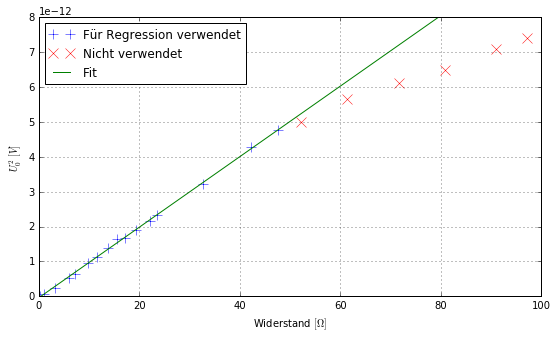

In [107]:
daten = pd.read_csv('daten_wid2.csv', header=0, delimiter='\t', names=['widerstand', 'voltage','vN'])

daten = daten.fillna(method='pad')
daten.index = daten.widerstand
daten.voltage /= 1000 #in Volt umrechnen

# Verstärkungen aufzählen
V_V = 1000 #Vorverstärkung
V_N = daten.vN #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

daten['voltageNormed'] = daten.voltage / (V_gl * V_N**2 * V_V**2)


noFit = daten.query('widerstand > 50')
daten = daten.query('widerstand <= 50')

# Fit
popt, pcov = curve_fit(gerade, daten.widerstand, daten.voltageNormed)
perr = np.sqrt(np.diag(pcov))

x = np.linspace(0, 100, 20)
y = gerade(x,popt[0], popt[1])
m = unc.ufloat(popt[0], perr[0])
b = unc.ufloat(popt[1], perr[1])
kB2 = m/(4 * deltaNu1 * 293.15)

with open("results/wid2_m.fit", "w") as text_file:
    print('{:.3L}'.format(m), file=text_file)
    print('m={:.3L}'.format(m))
with open("results/wid2_b.fit", "w") as text_file:
    print('{:.3L}'.format(b), file=text_file)
    print('b={:.3L}'.format(b))
with open("results/wid2_kb.fit", "w") as text_file:
    print('{:.3L}'.format(kB2), file=text_file)
    print('kB={:.3L}'.format(kB2))

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
daten.voltageNormed.plot(ax=ax, linestyle='', marker='+', color='blue', markersize=10, label='Für Regression verwendet')
noFit.voltageNormed.plot(ax=ax, linestyle='', marker='x', color='red', markersize=10, label='Nicht verwendet')




ax.plot(x,y, label='Fit', color='green')
ax.set_xlim((0,100))
ax.set_ylim((0,0.8e-11))
ax.set_xlabel('Widerstand $[\Omega]$')
ax.set_ylabel('$U_0^2\ [V]$')
ax.grid()
ax.legend(loc='best')
fig.savefig('results/wid2.pdf')


daten['v'] = daten.voltageNormed*1e13
#daten.to_latex('latex_wid2', float_format='%2.3f', header=False, index=False, columns=['widerstand','vN','v'])

plt.show()

### Widerstand 1 Korrel

m=\left(3.11 \pm 0.01\right) \times 10^{-17}
b=\left(-6.43 \pm 5.35\right) \times 10^{-17}
kB=\left(3.68 \pm 0.01\right) \times 10^{-23}
            widerstand  voltage     vN  voltageNormed
widerstand                                           
50.0              50.0    0.387  500.0   1.548000e-15
100.0            100.0    0.780  500.0   3.120000e-15
148.2            148.2    1.120  500.0   4.480000e-15
201.0            201.0    1.540  500.0   6.160000e-15
250.0            250.0    0.309  200.0   7.725000e-15


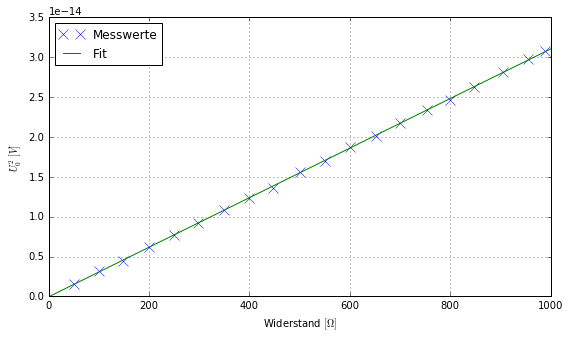

In [108]:
daten = pd.read_csv('daten_korrel_wid1.csv', header=0, delimiter='\t', names=['widerstand', 'voltage','vN'])
daten = daten.fillna(method='pad')
daten.index = daten.widerstand
daten.voltage /= 1000 #in Volt umrechnen

# Verstärkungen aufzählen
V_V = 1000 #Vorverstärkung
V_S = 10   #Selektive Verstärkung
V_N = daten.vN #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

daten['voltageNormed'] = daten.voltage / (V_gl * V_S**2 * V_N**2 * V_V**2)


# Fit
popt, pcov = curve_fit(gerade, daten.widerstand, daten.voltageNormed)
perr = np.sqrt(np.diag(pcov))
m = unc.ufloat(popt[0], perr[0])
b = unc.ufloat(popt[1], perr[1])
kB1_korrel = m/(4 * deltaNu2 * 293.15)

with open("results/wid1_korrel_m.fit", "w") as text_file:
    print('{:.3L}'.format(m), file=text_file)
    print('m={:.3L}'.format(m))
with open("results/wid1_korrel_b.fit", "w") as text_file:
    print('{:.3L}'.format(b), file=text_file)
    print('b={:.3L}'.format(b))
with open("results/wid1_korrel_kb.fit", "w") as text_file:
    print('{:.3L}'.format(kB1_korrel), file=text_file)
    print('kB={:.3L}'.format(kB1_korrel))

x = np.linspace(0, 1000, 20)
y = gerade(x,popt[0], popt[1])


fig = plt.figure(figsize=(9,5))
daten.voltageNormed.plot(linestyle='', marker='x', markersize=10, label='Messwerte')
plt.plot(x,y, label='Fit')
plt.xlim((0,1000))
plt.ylim((0,3.5e-14))
plt.xlabel('Widerstand $[\Omega]$')
plt.ylabel('$U_0^2\ [V]$')
plt.grid()
plt.legend(loc='best')
plt.savefig('results/wid1_korrel.pdf')


daten['v'] = daten.voltageNormed*1e14
#daten.to_latex('latex_wid1_korrel', float_format='%2.3f', header=False, index=False, columns=['widerstand','vN','v'])

plt.show()

### Widerstand 2 Korrel

m=\left(2.81 \pm 0.02\right) \times 10^{-14}
b=\left(1.62 \pm 2.08\right) \times 10^{-15}
kB=\left(3.32 \pm 0.03\right) \times 10^{-20}
            widerstand  voltage      vN  voltageNormed
widerstand                                            
0.0064          0.0064    0.226  1000.0   2.260000e-16
0.1530          0.1530    1.120  1000.0   1.120000e-15
0.6800          0.6800    0.840   200.0   2.100000e-14
1.4200          1.4200    1.660   200.0   4.150000e-14
2.5100          2.5100    0.690   100.0   6.900000e-14


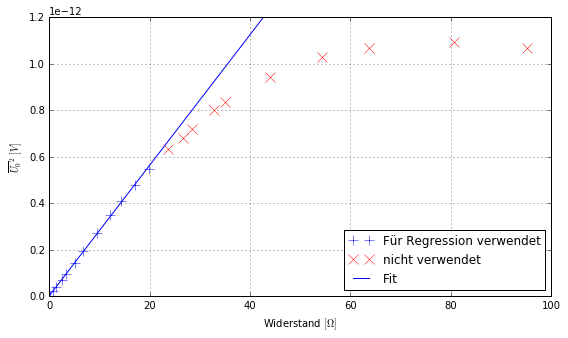

In [109]:
daten = pd.read_csv('daten_korrel_wid2.csv', header=0, delimiter='\t', names=['widerstand', 'voltage','vN'])
daten = daten.fillna(method='pad')
daten.index = daten.widerstand
daten.voltage /= 1000 #in Volt umrechnen

# Verstärkungen aufzählen
V_V = 1000 #Vorverstärkung
V_S = 10   #Selektive Verstärkung
V_N = daten.vN #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

daten['voltageNormed'] = daten.voltage / (V_gl * V_S**2 * V_N**2 * V_V**2)


fit = daten.query('widerstand <= 20')
noFit = daten.query('widerstand > 20')

# Fit
popt, pcov = curve_fit(gerade, fit.widerstand, fit.voltageNormed)
perr = np.sqrt(np.diag(pcov))
m = unc.ufloat(popt[0], perr[0])
b = unc.ufloat(popt[1], perr[1])
kB2_korrel = m/(4 * deltaNu2 * 293.15)

with open("results/wid2_korrel_m.fit", "w") as text_file:
    print('{:.3L}'.format(m), file=text_file)
    print('m={:.3L}'.format(m))
with open("results/wid2_korrel_b.fit", "w") as text_file:
    print('{:.3L}'.format(b), file=text_file)
    print('b={:.3L}'.format(b))
with open("results/wid2_korrel_kb.fit", "w") as text_file:
    print('{:.3L}'.format(kB2_korrel), file=text_file)
    print('kB={:.3L}'.format(kB2_korrel))

x = np.linspace(0, 50, 20)
y = gerade(x,popt[0], popt[1])
    
fig = plt.figure(figsize=(9,5))
fit.voltageNormed.plot(linestyle='', marker='+', markersize=10, color = 'blue', label='Für Regression verwendet')
noFit.voltageNormed.plot(linestyle='', marker='x', markersize=10, color='red', label='nicht verwendet')
plt.plot(x,y, label='Fit')

plt.xlim((0,100))
plt.ylim((0,1.2e-12))
plt.xlabel('Widerstand $[\Omega]$')
plt.ylabel('$\overline{U_0}^2\ [V]$')
plt.grid()
plt.legend(loc='best')
plt.savefig('results/wid2_korrel.pdf')


daten['v'] = daten.voltageNormed*1e14
#daten.to_latex('latex_wid2_korrel', float_format='%2.3f', header=False, index=False, columns=['widerstand','vN','v'])

plt.show()

# Glühkathoden

          spannung     9   925
spannung                      
10.0          10.0  1.10  1.15
17.5          17.5  2.20  2.25
26.0          26.0  3.00  3.40
36.0          36.0  3.10  4.40
45.0          45.0  3.15  4.80


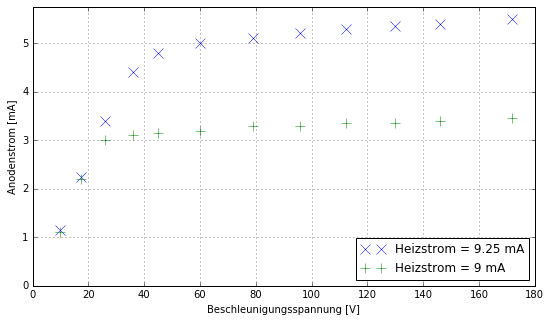

In [110]:
daten = pd.read_csv('reinMet_Sat9.csv', header=0, delimiter='\t', names=['spannung', '9'])
daten2 = pd.read_csv('reinMet_Sat925.csv', header=0, delimiter='\t', names=['spannung', 'strom'])
daten['925'] = daten2['strom']
daten.index = daten.spannung

fig = plt.figure(figsize=(9,5))
daten['925'].plot(linestyle='', marker='x', markersize=10, label="Heizstrom = 9.25 mA")
daten['9'].plot(linestyle='', marker='+', markersize=10, label="Heizstrom = 9 mA")
plt.xlim((0,180))
plt.ylim((0,5.75))
plt.xlabel('Beschleunigungsspannung [V]')
plt.ylabel('Anodenstrom [mA]')
plt.grid()
plt.legend(loc='lower right')
plt.savefig('results/kathRein_sat.pdf')


#daten.to_latex('latex_kennlinie', float_format='%2.2f', header=False, index=False, columns=['spannung','9','925'])

plt.show()

### Oxidkathode

m=-0.0358 \pm 0.0092
b=-21.2 \pm 0.0
m=-1.05 \pm 0.06
b=-17.8 \pm 0.1
F=-1.05 \pm 0.06
W=\left(6.19 \pm 0.66\right) \times 10^{-22}


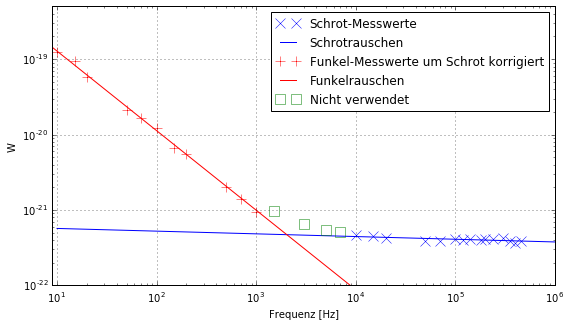

In [115]:
daten = pd.read_csv('oxidKath_K.csv', header=0, delimiter='\t', names=['frequenz', 'spannung_mean', 'spannung_min', 'spannung_max', 'gain', 'dNu'])
daten['frequenz_Hz'] = daten.frequenz * 1000
daten['dNu'] = daten.apply(lambda x: fillNu(x,2200), axis=1)
daten = daten.fillna(method='pad')
daten['spannung_mean'] /= 1000
daten['spannung_min'] /= 1000
daten['spannung_max'] /= 1000

daten.index = daten.frequenz_Hz


# schätze Fehler durch Standardabweichung ab
err = lambda x : np.sqrt((x.spannung_mean - x.spannung_min)**2 + (x.spannung_mean - x.spannung_max)**2)


V_V = 1000 #Vorverstärkung
V_N = daten.gain #Nachverstärker
V_S = np.ones(len(daten.index))          #Selektive Verstärkung
V_S[daten.index.values <= 1e5] *= 10  #nur bis 100khz, danach keine selektive Verstärkung
V_gl = 10 #Gleichspannungsverstärker

daten['spannungNormed'] = daten.spannung_mean / (V_V * V_N * V_S)**2 /V_gl
daten['spannung_error'] = daten.apply(err, axis=1) / (V_V * V_N * V_S)**2 /V_gl
daten.sort_index(inplace=True)

daten['rausch'] = daten.spannungNormed / 2200**2 / daten.dNu

schrot = daten.query('frequenz_Hz > 9900')
funkel = daten.query('frequenz_Hz <= 1000')
nicht = daten.query('1000 < frequenz_Hz <= 9900')


# Fit
popt, pcov = curve_fit(eFunk,schrot.frequenz_Hz, schrot.rausch)
perr = np.sqrt(np.diag(pcov))
m1 = unc.ufloat(popt[0], perr[0])
b1 = unc.ufloat(popt[1], perr[1])
popt, pcov = curve_fit(
    eFunk,
    funkel.frequenz_Hz,
    (funkel.rausch - eFunk(funkel.frequenz_Hz, m1.n, b1.n)))
perr = np.sqrt(np.diag(pcov))
m2 = unc.ufloat(popt[0], perr[0])
b2 = unc.ufloat(popt[1], perr[1])

with open("results/oxid_schrot_m.fit", "w") as text_file:
    print('{:.3L}'.format(m1), file=text_file)
    print('m={:.3L}'.format(m1))
with open("results/oxid_schrot_b.fit", "w") as text_file:
    print('{:.3L}'.format(b1), file=text_file)
    print('b={:.3L}'.format(b1))

with open("results/oxid_funkel_m.fit", "w") as text_file:
    print('{:.3L}'.format(m2), file=text_file)
    print('m={:.3L}'.format(m2))
with open("results/oxid_funkel_b.fit", "w") as text_file:
    print('{:.3L}'.format(b2), file=text_file)
    print('b={:.3L}'.format(b2))

with open("results/oxid_funkel_F.fit", "w") as text_file:
    print('{:.3L}'.format(m2), file=text_file)
    print('F={:.3L}'.format(m2))
with open("results/oxid_schrot_W.fit", "w") as text_file:
    print('{:.3L}'.format(10**b1), file=text_file)
    print('W={:.3L}'.format(10**b1))


x1 = np.linspace(10, 1e6, 10)
x2 = np.linspace(9, 10000, 10)
y1 = eFunk(x1, m1.n, b1.n)
y2 = eFunk(x2, m2.n, b2.n)

fig = plt.figure(figsize=(9,5))
schrot.rausch.plot(linestyle='', marker='x', markersize=10, color = 'blue', label='Schrot-Messwerte')
plt.plot(x1, y1, label='Schrotrauschen', color='blue')
funkel.rausch.plot(linestyle='', marker='+', markersize=10, color = 'red', label='Funkel-Messwerte um Schrot korrigiert')
plt.plot(x2, y2, label='Funkelrauschen', color='red')
nicht.rausch.plot(linestyle='', marker='s', fillstyle='none', markersize=10, color = 'green', label='Nicht verwendet')

plt.xlabel('Frequenz [Hz]')
plt.ylabel('W')
plt.ylim((10e-23,50e-20))
plt.loglog()
plt.legend(loc='best')
plt.grid()
plt.savefig('results/oxid_rausch.pdf')

tab = daten
tab['mean'] = daten.spannungNormed*1e13
tab['error'] = daten.spannung_error*1e13
#tab.to_latex('latex_oxid_rauschen', float_format='%2.2f', header=False, index=False, columns=['frequenz','gain','dNu','mean','error'])

plt.show()

### Reinkathode e0

m=\left(3.09 \pm 0.02\right) \times 10^{-10}
b=\left(-2.88 \pm 0.63\right) \times 10^{-14}
e0=\left(3.30 \pm 0.02\right) \times 10^{-18}
             anodenStrom  rauschspannung  gain   stromNormed
anodenStrom                                                 
0.0005            0.0005           0.645  10.0  1.378205e-13
0.0010            0.0010           1.310  10.0  2.799145e-13
0.0015            0.0015           1.975  10.0  4.220085e-13
0.0020            0.0020           0.695   5.0  5.940171e-13
0.0025            0.0025           0.865   5.0  7.393162e-13
0.0030            0.0030           1.050   5.0  8.974359e-13
0.0035            0.0035           1.227   5.0  1.048718e-12
0.0040            0.0040           1.400   5.0  1.196581e-12
0.0045            0.0045           1.590   5.0  1.358974e-12
0.0050            0.0050           1.790   5.0  1.529915e-12


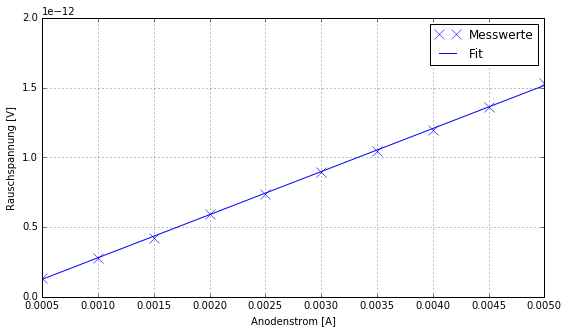

In [112]:
daten = pd.read_csv('reinMet_e0.csv', header=0, delimiter='\t', names=['anodenStrom', 'rauschspannung', 'gain'])
daten = daten.fillna(method='pad')

daten.index = daten.anodenStrom
daten['anodenStrom'] = daten.anodenStrom / 1000
daten['rauschspannung'] = daten.rauschspannung / 1000

V_V = 1000 #Vorverstärkung
V_N = daten.gain #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

daten['stromNormed'] = daten.rauschspannung / (V_V * V_N)**2 / 4680 / V_gl

# Fit
popt, pcov = curve_fit(gerade, daten.anodenStrom, daten.stromNormed, p0=[0,1e-15])
perr = np.sqrt(np.diag(pcov))
m = unc.ufloat(popt[0], perr[0])
b = unc.ufloat(popt[1], perr[1])
e0 = m/2 /10000 / 4680

with open("results/rein_m.fit", "w") as text_file:
    print('{:.3L}'.format(m), file=text_file)
    print('m={:.3L}'.format(m))
with open("results/rein_b.fit", "w") as text_file:
    print('{:.3L}'.format(b), file=text_file)
    print('b={:.3L}'.format(b))
with open("results/rein_e0.fit", "w") as text_file:
    print('{:.3L}'.format(e0), file=text_file)
    print('e0={:.3L}'.format(e0))

x = np.linspace(0, 5e-3, 10)
y = gerade(x,popt[0], popt[1])

fig = plt.figure(figsize=(9,5))
daten.stromNormed.plot(linestyle='', marker='x', markersize=10, color = 'blue', label='Messwerte')
plt.plot(x,y, label='Fit')
plt.xlabel('Anodenstrom [A]')
plt.ylabel('Rauschspannung [V]')
plt.ylim((0,2e-12))
plt.grid()
plt.legend(loc='best')
plt.savefig('results/rein_e0.pdf')

tab = daten
print(daten)
tab['stromNormed'] = daten.stromNormed*1e13
tab['anodenStrom'] = daten.anodenStrom*1000
#tab.to_latex('latex_rein_e0', float_format='%2.2f', header=False, index=False, columns=['anodenStrom','gain','stromNormed'])

plt.show()

### Reinkathode Rauschspektrum

In [ ]:
### daten = pd.read_csv('reinMet_K.csv', header=0, delimiter='\t', names=['frequenz', 'spannung_mean', 'spannung_min', 'spannung_max', 'gain','dNu'])
daten['frequenz_Hz'] = daten.frequenz * 1000
daten['dNu'] = daten.apply(lambda x: fillNu(x, 4680), axis=1)
daten['spannung_mean'] /= 1000
daten['spannung_min'] /= 1000
daten['spannung_max'] /= 1000
daten = daten.fillna(method='pad')

daten.index = daten.frequenz_Hz


# schätze Fehler durch Standardabweichung ab
err = lambda x : np.sqrt((x.spannung_mean - x.spannung_min)**2 + (x.spannung_mean - x.spannung_max)**2)


V_V = 1000 #Vorverstärkung
V_N = daten.gain #Nachverstärker
V_S = np.ones(len(daten.index))          #Selektive Verstärkung
V_S[daten.index.values <= 1e5] *= 10  #nur bis 100khz, danach keine selektive Verstärkung
V_gl = 10 #Gleichspannungsverstärker

daten['spannungNormed'] = daten.spannung_mean / (V_V * V_N  * V_S)**2 / V_gl
daten['spannung_error'] = daten.apply(err, axis=1) / (V_V * V_N * V_S)**2 /V_gl
daten.sort_index(inplace=True)

daten['rausch'] = daten.spannungNormed / 4680**2 / daten.dNu

schrot = daten.query('frequenz_Hz > 105')
funkel = daten.query('frequenz_Hz <= 60')
nicht = daten.query('60 < frequenz_Hz <= 105')


# Fit
popt, pcov = curve_fit(eFunk,schrot.frequenz_Hz, schrot.rausch)
perr = np.sqrt(np.diag(pcov))
m1 = unc.ufloat(popt[0], perr[0])
b1 = unc.ufloat(popt[1], perr[1])
popt, pcov = curve_fit(
    eFunk,
    funkel.frequenz_Hz,
    (funkel.rausch - eFunk(funkel.frequenz_Hz, m1.n, b1.n)))
perr = np.sqrt(np.diag(pcov))
m2 = unc.ufloat(popt[0], perr[0])
b2 = unc.ufloat(popt[1], perr[1])

with open("results/rein_schrot_m.fit", "w") as text_file:
    print('{:.3L}'.format(m1), file=text_file)
    print('m={:.3L}'.format(m1))
with open("results/rein_schrot_b.fit", "w") as text_file:
    print('{:.3L}'.format(b1), file=text_file)
    print('b={:.3L}'.format(b1))

with open("results/rein_funkel_m.fit", "w") as text_file:
    print('{:.3L}'.format(m2), file=text_file)
    print('m={:.3L}'.format(m2))
with open("results/rein_funkel_b.fit", "w") as text_file:
    print('{:.3L}'.format(b2), file=text_file)
    print('b={:.3L}'.format(b2))

with open("results/rein_funkel_F.fit", "w") as text_file:
    print('{:.3L}'.format(m2), file=text_file)
    print('F={:.3L}'.format(m2))
with open("results/rein_schrot_W.fit", "w") as text_file:
    print('{:.3L}'.format(10**b1), file=text_file)
    print('W={:.3L}'.format(10**b1))


x1 = np.linspace(10, 10e6, 10)
x2 = np.linspace(9, 1000, 10)
y1 = eFunk(x1, m1.n, b1.n)
y2 = eFunk(x2, m2.n, b2.n)

fig = plt.figure(figsize=(9,5))
schrot.rausch.plot(linestyle='', marker='x', markersize=10, color = 'blue', label='Schrot-Messwerte')
plt.plot(x1, y1, label='Schrotrauschen', color='blue')
funkel.rausch.plot(linestyle='', marker='x', markersize=10, color = 'red', label='Funkel-Messwerte um Schrot korrigiert')
plt.plot(x2, y2, label='Funkelrauschen', color='red')
nicht.rausch.plot(linestyle='', marker='s', fillstyle='none', markersize=10, color = 'green', label='Nicht verwendet')

plt.xlabel('Frequenz [Hz]')
plt.ylabel('W')
plt.ylim((1e-22,1e-18))
plt.loglog()
plt.legend(loc='best')
plt.grid()
plt.savefig('results/rein_rausch.pdf')

tab = daten
tab['mean'] = daten.spannungNormed*1e13
tab['error'] = daten.spannung_error*1e13
#tab.to_latex('latex_rein_rauschen', float_format='%2.2f', header=False, index=False, columns=['frequenz','gain','dNu','mean','error'])

plt.show()